# 8章

以下のサイトを参考にコードを記述。

https://mori-memo.hateblo.jp/archive/category/%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86100%E6%9C%AC%E3%83%8E%E3%83%83%E3%82%AF

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2024-01-04 15:11:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip.3’

NewsAggregatorDatas     [          <=>       ]  27.87M  10.6MB/s    in 2.6s    

2024-01-04 15:11:31 (10.6 MB/s) - ‘NewsAggregatorDataset.zip.3’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())


【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
zdffrom google.colab import drive
drive.mount('/content/drive')
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('drive/MyDrive/100knock/GoogleNews-vectors-negative300.bin.gz', binary=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [ ]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)


torch.Size([10684, 300])
tensor([[ 0.0837,  0.0056,  0.0068,  ...,  0.0751,  0.0433, -0.0868],
        [ 0.0272,  0.0266, -0.0947,  ..., -0.1046, -0.0489, -0.0092],
        [ 0.0577, -0.0159, -0.0780,  ..., -0.0421,  0.1229,  0.0876],
        ...,
        [ 0.0392, -0.0052,  0.0686,  ..., -0.0175,  0.0061, -0.0224],
        [ 0.0798,  0.1017,  0.1066,  ..., -0.0752,  0.0623,  0.1138],
        [ 0.1664,  0.0451,  0.0508,  ..., -0.0531, -0.0183, -0.0039]])


In [ ]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10684])
tensor([0, 1, 3,  ..., 0, 3, 2])


In [ ]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

In [ ]:
from torch import nn

class SLPNet(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

In [ ]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.4706, 0.1677, 0.1792, 0.1824]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4706, 0.1677, 0.1792, 0.1824],
        [0.0094, 0.8939, 0.0866, 0.0101],
        [0.1284, 0.1007, 0.2062, 0.5646],
        [0.7295, 0.1283, 0.0890, 0.0531]], grad_fn=<SoftmaxBackward0>)


In [ ]:
criterion = nn.CrossEntropyLoss()
l_1 = criterion(model(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 0.7536
勾配:
tensor([[-0.0443, -0.0030, -0.0036,  ..., -0.0398, -0.0229,  0.0459],
        [ 0.0140,  0.0009,  0.0011,  ...,  0.0126,  0.0073, -0.0146],
        [ 0.0150,  0.0010,  0.0012,  ...,  0.0135,  0.0078, -0.0156],
        [ 0.0153,  0.0010,  0.0012,  ...,  0.0137,  0.0079, -0.0158]])


In [ ]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 0.9640
勾配:
tensor([[-0.0193,  0.0079,  0.0077,  ..., -0.0140,  0.0052,  0.0105],
        [ 0.0025,  0.0007,  0.0028,  ...,  0.0044,  0.0075, -0.0018],
        [ 0.0200, -0.0113, -0.0199,  ...,  0.0020, -0.0017,  0.0051],
        [-0.0031,  0.0027,  0.0094,  ...,  0.0076, -0.0110, -0.0138]])


In [ ]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [ ]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()

  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval()
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

epoch: 1, loss_train: 0.4512, loss_valid: 0.3500
epoch: 2, loss_train: 0.3089, loss_valid: 0.3231
epoch: 3, loss_train: 0.2808, loss_valid: 0.3152
epoch: 4, loss_train: 0.2660, loss_valid: 0.3079
epoch: 5, loss_train: 0.2565, loss_valid: 0.3045
epoch: 6, loss_train: 0.2490, loss_valid: 0.3075
epoch: 7, loss_train: 0.2443, loss_valid: 0.3081
epoch: 8, loss_train: 0.2398, loss_valid: 0.3031
epoch: 9, loss_train: 0.2359, loss_valid: 0.3071
epoch: 10, loss_train: 0.2329, loss_valid: 0.3084


In [ ]:
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.922
正解率（評価データ）：0.906


In [ ]:
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.3280, accuracy_train: 0.8867, loss_valid: 0.3613, accuracy_valid: 0.8720
epoch: 2, loss_train: 0.2840, accuracy_train: 0.9035, loss_valid: 0.3239, accuracy_valid: 0.8877
epoch: 3, loss_train: 0.2684, accuracy_train: 0.9071, loss_valid: 0.3199, accuracy_valid: 0.8900
epoch: 4, loss_train: 0.2522, accuracy_train: 0.9161, loss_valid: 0.3109, accuracy_valid: 0.8900
epoch: 5, loss_train: 0.2432, accuracy_train: 0.9179, loss_valid: 0.3051, accuracy_valid: 0.8930
epoch: 6, loss_train: 0.2368, accuracy_train: 0.9196, loss_valid: 0.3045, accuracy_valid: 0.8990
epoch: 7, loss_train: 0.2347, accuracy_train: 0.9223, loss_valid: 0.3041, accuracy_valid: 0.8990
epoch: 8, loss_train: 0.2291, accuracy_train: 0.9228, loss_valid: 0.3040, accuracy_valid: 0.8982
epoch: 9, loss_train: 0.2269, accuracy_train: 0.9230, loss_valid: 0.3075, accuracy_valid: 0.8967
epoch: 10, loss_train: 0.2247, accuracy_train: 0.9261, loss_valid: 0.3052, accuracy_valid: 0.8960
epoch: 11, loss_train: 0.2235

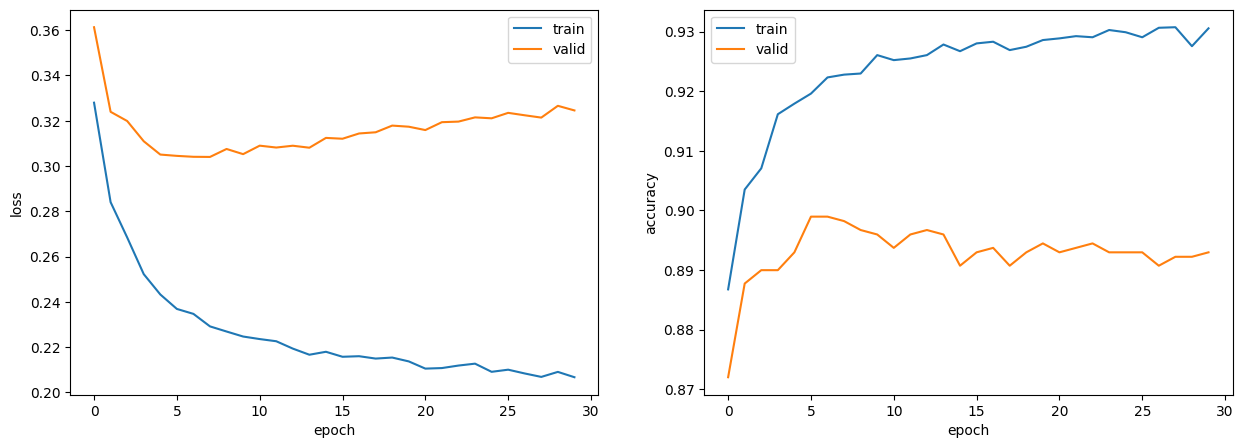

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [ ]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')


epoch: 1, loss_train: 0.3343, accuracy_train: 0.8857, loss_valid: 0.3584, accuracy_valid: 0.8862
epoch: 2, loss_train: 0.2881, accuracy_train: 0.9014, loss_valid: 0.3234, accuracy_valid: 0.8877
epoch: 3, loss_train: 0.2673, accuracy_train: 0.9098, loss_valid: 0.3096, accuracy_valid: 0.8930
epoch: 4, loss_train: 0.2551, accuracy_train: 0.9145, loss_valid: 0.3040, accuracy_valid: 0.8982
epoch: 5, loss_train: 0.2472, accuracy_train: 0.9180, loss_valid: 0.3011, accuracy_valid: 0.8990
epoch: 6, loss_train: 0.2406, accuracy_train: 0.9198, loss_valid: 0.2997, accuracy_valid: 0.8945
epoch: 7, loss_train: 0.2352, accuracy_train: 0.9231, loss_valid: 0.2981, accuracy_valid: 0.8937
epoch: 8, loss_train: 0.2320, accuracy_train: 0.9236, loss_valid: 0.2980, accuracy_valid: 0.8945
epoch: 9, loss_train: 0.2287, accuracy_train: 0.9239, loss_valid: 0.2993, accuracy_valid: 0.8937
epoch: 10, loss_train: 0.2302, accuracy_train: 0.9235, loss_valid: 0.3036, accuracy_valid: 0.8982


In [ ]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [ ]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)


バッチサイズ: 1
epoch: 1, loss_train: 0.3289, accuracy_train: 0.8892, loss_valid: 0.3551, accuracy_valid: 0.8817, 7.2069sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3007, accuracy_train: 0.8994, loss_valid: 0.3302, accuracy_valid: 0.8855, 5.0481sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2922, accuracy_train: 0.9033, loss_valid: 0.3237, accuracy_valid: 0.8892, 2.4755sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2885, accuracy_train: 0.9028, loss_valid: 0.3234, accuracy_valid: 0.8922, 1.2321sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2861, accuracy_train: 0.9047, loss_valid: 0.3207, accuracy_valid: 0.8922, 0.7623sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2851, accuracy_train: 0.9060, loss_valid: 0.3200, accuracy_valid: 0.8922, 0.6912sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2846, accuracy_train: 0.9056, loss_valid: 0.3199, accuracy_valid: 0.8930, 0.3322sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2844, accuracy_train: 0.9057, loss_valid: 0.3197, accuracy_valid: 0.8930, 0.2452sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2850, accuracy_

In [ ]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
  return loss / len(loader), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [ ]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)


バッチサイズ: 1
epoch: 1, loss_train: 0.3202, accuracy_train: 0.8877, loss_valid: 0.3484, accuracy_valid: 0.8787, 16.6805sec
バッチサイズ: 2
epoch: 1, loss_train: 0.2942, accuracy_train: 0.8983, loss_valid: 0.3272, accuracy_valid: 0.8900, 7.2480sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2853, accuracy_train: 0.9012, loss_valid: 0.3216, accuracy_valid: 0.8892, 3.4529sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2814, accuracy_train: 0.9021, loss_valid: 0.3192, accuracy_valid: 0.8900, 1.7914sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2797, accuracy_train: 0.9030, loss_valid: 0.3184, accuracy_valid: 0.8915, 0.9997sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2790, accuracy_train: 0.9039, loss_valid: 0.3178, accuracy_valid: 0.8915, 0.5653sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2786, accuracy_train: 0.9040, loss_valid: 0.3176, accuracy_valid: 0.8915, 0.3577sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2787, accuracy_train: 0.9042, loss_valid: 0.3175, accuracy_valid: 0.8915, 0.2432sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2781, accuracy

In [ ]:
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size)
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

In [ ]:
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [ ]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)


epoch: 1, loss_train: 0.9079, accuracy_train: 0.7530, loss_valid: 0.9032, accuracy_valid: 0.7635, 0.5893sec
epoch: 2, loss_train: 0.7327, accuracy_train: 0.7705, loss_valid: 0.7280, accuracy_valid: 0.7725, 0.6047sec
epoch: 3, loss_train: 0.6559, accuracy_train: 0.7779, loss_valid: 0.6532, accuracy_valid: 0.7769, 0.6759sec
epoch: 4, loss_train: 0.6074, accuracy_train: 0.7854, loss_valid: 0.6066, accuracy_valid: 0.7822, 0.6757sec
epoch: 5, loss_train: 0.5673, accuracy_train: 0.7924, loss_valid: 0.5688, accuracy_valid: 0.7912, 0.6993sec
epoch: 6, loss_train: 0.5353, accuracy_train: 0.8041, loss_valid: 0.5391, accuracy_valid: 0.8054, 0.7013sec
epoch: 7, loss_train: 0.5084, accuracy_train: 0.8179, loss_valid: 0.5142, accuracy_valid: 0.8129, 0.6768sec
epoch: 8, loss_train: 0.4840, accuracy_train: 0.8299, loss_valid: 0.4922, accuracy_valid: 0.8226, 0.7314sec
epoch: 9, loss_train: 0.4605, accuracy_train: 0.8423, loss_valid: 0.4710, accuracy_valid: 0.8331, 0.5406sec
epoch: 10, loss_train: 0.440

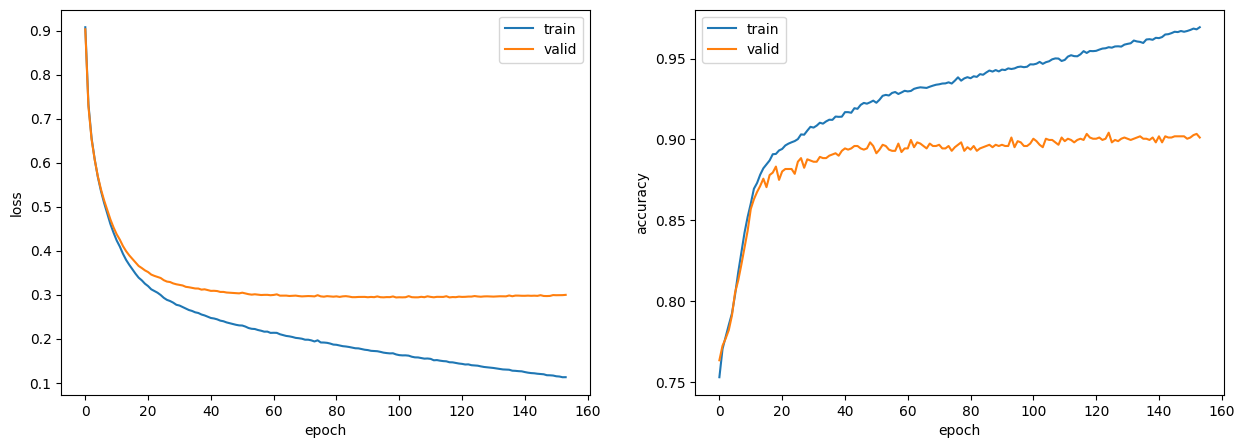

In [ ]:
from matplotlib import pyplot as plt
import numpy as np


# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [ ]:
def calculate_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

In [ ]:
# 正解率の確認
acc_train = calculate_accuracy(model, dataloader_train, device)
acc_test = calculate_accuracy(model, dataloader_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.969
正解率（評価データ）：0.912
